
<div class="alert alert-block alert-info">
   <h2 align="center"> <center><b> Reinforcement Learning Assignment 6 - Actor Critic part 2 </b></center></h2>

<br>
<center><font size="3">This notebook is part of the teaching material for ELEC-E8125</font></center>
<center><font size="3">Aalto University</font></center>
</div>


<a id='TOC'></a>

<div class="alert alert-block alert-success">
    
# Table of contents
* <a href='#1.'> 1. Introduction </a>
* <a href='#1.1'> 1.1 Learning Objectives </a>
* <a href='#1.2'> 1.2 Code Structure & Files </a>
* <a href='#2.'> 2. Deep Deterministic Policy Gradient</a>
* <a href='#3.'> 3. Submitting </a>
* <a href='#3.1'> 3.1 Feedback </a>
* <a href='#8.'> References</a>

<a href='#T1'><b>Student Task 1.</b> Implement DDPG algorithm (25 points)</a>\
<a href='#Q1'><b>Student Question 1.1</b> Reasons for using off-policy data (10 points) </a>\
<a href='#Q2'><b>Student Question 2</b> Disadvantages of DDPG (10 points) </a>

    
**Total Points:** 45

**Estimated runtime of all the cells:** 1 hour

# 1. Introduction <a id='1.'></a>
In this assignment, we will implement the Deep Deterministic Policy Gradient (DDPG) [1] algorithm for the **HalfCheetah-v4** environment. DDPG is a reinforcement learning algorithm that uses a critic, approximated as a neural network, to estimate values. DDPG uses policy gradient methods to update a deterministic policy (actor) to follow the critic. DDPG can be applied to problems with a continuous action space.

## 1.1 Task environments: <a id='1.1'></a>

In this exercise, we will focus on HalfCheetah-v4 tasks:
- HalfCheetah-v4(https://gymnasium.farama.org/environments/mujoco/half_cheetah/): The HalfCheetah is a 2-dimensional robot consisting of 9 body parts and 8 joints connecting them (including two paws). The goal is to apply torques on the joints to make the cheetah run forward (right) as fast as possible, with a positive reward allocated based on the distance moved forward and a negative reward allocated for moving backward. The torso and head of the cheetah are fixed, and the torque can only be applied on the other 6 joints over the front and back thighs (connecting to the torso), shins (connecting to the thighs) and feet (connecting to the shins).
<figure style="text-align: center">
    <img src="imgs/HalfCheetah-v4.png" width="300"/>
    <figcaption style="text-align: center">  Figure 1: The HalfCheetah-v4 environment. </figcaption>
</figure>

## 1.2 Learning Objectives: <a id='1.2'></a>

- Understand the DDPG algorithm
- Understand the difference between on-policy methods and off-policy methods

## 1.3 Code Structure & Files <a id='1.3'></a>

```ex6_DDPG.ipynb``` is the file needed to be modified for this part of the assignment.  

<span style="color:red"> **# IMPORTANT: DO NOT FORGET ANOTHER PART IN ```ex6_PG_AC.ipynb```** </span>

```
├───cfg                            # Config files for environments
├───imgs                           # Images used in notebook
├───results
│   └───HalfCheetah-v4
│   │   ├───logging                
│   │   │    └───logging.pkl        # Contains logged data
│   │   ├───model              
│   │   │    └───*HalfCheetah-v4_params.pt    # Contains trained model
│   │   └───video                   # Videos saved
│   │   └───*ddpg.png               # Contains training performance plot
│   └───InvertedPendulum-v4
│   │   ├───logging                
│   │   │    └───logging.pkl        # Contains logged data
│   │   ├───model              
│   │   │    └───*InvertedPendulum-v4_params.pt      # Contains trained model
│   │   └───video                   # Videos saved
│   │   └───*pg_ac.png              # Contains training performance plot
│   ex6_DDPG.ipynb                  # 2nd assignment file containing tasks <---------This task
│   ex6_PG_AC.ipynb                 # 1st assignment file containing tasks <---------
│   train.py                        # Contains train and test functions 
│   utils.py                        # Contains useful functions 
└───buffer.py                       # Contains buffer functions
```

## 1.4 Execution time <a id='1.4'></a>

The training of DDPG might take more than 30 min depending on server load. If you have problems with the training time, you can train DDPG locally.

## Warnings:

- Don’t copy and paste cells within a notebook. This will mess up the tracking metadata and prevent autograding from working.
- Only add new cells using the '+' button in the upper toolbar and do not split cells.
- Be cautious about things such as copying the whole notebook to Colab to work on it. This has sometimes resulted in removing all notebook metadata, making autograding impossible.

# 2. Deep Deterministic Policy Gradient <a id='2.'></a>

<a id='T1'></a>
<div class=" alert alert-warning">
    <h3><b>Student Task 1.</b> Implementing DDPG (25 points) </h3> 

Implement the deep deterministic policy gradient (DDPG) algorithm for the HalfCheetah environment. You can refer to the code from the "ex4_dqn.ipynb" notebook for guidance. Additionally, if necessary, consult the paper [1] for a deeper understanding of the algorithm. You can check the training performance plot in the result folder after running the plot cell.Take Figure 2 as a reference training plot. 

<figure style="text-align: center">
<img src="imgs/ddpg.png" width="400px">
<figcaption style="text-align: center"> Figure 2:  Training plot of the deterministic policy gradient on the HalfCheetah environment.
</figcaption>
</figure>

**Complete the unfinished implementation in the `DDPG` class (marked with ```TODOs```)**. 
    
1. **Agent Update Function**: Finish the `_update(self, )` function within the `DDPG` class
2. **Get Action Method**: Finish the `get_action(self, observation, evaluation=False)` function within the `DDPG` class.

**Hint:** Make always sure variables have correct dimensions!
    
    
🔝	<a href='#TOC'><b>Table of Contents</b></a>
</div>


In [1]:
skip_training = True  # Set this flag to True before validation and submission

In [2]:
import sys, os
sys.path.insert(0, os.path.abspath(".."))

import numpy as np
from pathlib import Path
from IPython.display import Video

import copy, torch, yaml, time
from torch import nn
import torch.nn.functional as F
from buffer import ReplayBuffer

import train as t
import utils as u

device = 'cpu'

In [3]:
# Actor-critic agent

# Policy class. The policy is represented by a neural network. 
# Reminder: in DDPG the policy is deterministic.
class Policy(nn.Module):
    def __init__(self, state_dim, action_dim, max_action):
        super().__init__()
        self.max_action = max_action
        self.actor = nn.Sequential(
            nn.Linear(state_dim, 32), nn.ReLU(),
            nn.Linear(32, 32), nn.ReLU(),
            nn.Linear(32, action_dim)
        )

    def forward(self, state):
        return self.max_action * torch.tanh(self.actor(state))


# Critic class. The critic is represented by a neural network.
class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.value = nn.Sequential(
            nn.Linear(state_dim+action_dim, 32), nn.ReLU(),
            nn.Linear(32, 32), nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, state, action):
        x = torch.cat([state, action], 1)
        return self.value(x) # output shape [batch, 1]


class DDPG(object):
    def __init__(self, state_shape, action_dim, max_action, lr, gamma, tau, batch_size, buffer_size=1e6):
        self.name = 'ddpg'
        state_dim = state_shape[0]
        self.action_dim = action_dim
        self.max_action = max_action
        self.pi = Policy(state_dim, action_dim, max_action).to(device)
        self.pi_target = copy.deepcopy(self.pi)
        self.pi_optim = torch.optim.Adam(self.pi.parameters(), lr=float(lr))

        self.q = Critic(state_dim, action_dim).to(device)
        self.q_target = copy.deepcopy(self.q)
        self.q_optim = torch.optim.Adam(self.q.parameters(), lr=float(lr))
        
        self.buffer = ReplayBuffer(state_shape, action_dim, max_size=int(float(buffer_size)))
        
        self.batch_size = batch_size
        self.gamma = gamma
        self.tau = tau
        
        # used to count number of transitions in a trajectory
        self.buffer_ptr = 0
        self.buffer_head = 0 
        self.random_transition = 5000 # collect 5k random data for better exploration
    
    def update(self,):
        """ After collecting one trajectory, update the pi and q for #transition times: """
        info = {}
        update_iter = self.buffer_ptr - self.buffer_head # update the network once per transition

        if self.buffer_ptr > self.random_transition: # update once we have enough data
            for _ in range(update_iter):
                info = self._update()
        
        # update the buffer_head:
        self.buffer_head = self.buffer_ptr
        return info

    '''
    # TODO: Task 2
    # Complete the following 3 functions
    # Hints: 1. Compute the target Q value using the q_target and pi_target networks.
    #        2. compute the critic loss and update the q's parameters
    #        3. compute actor loss and update the pi's parameters
    #        4. Use mean to calculate the actor (policy) loss ;)
    #           - https://discuss.pytorch.org/t/loss-reduction-sum-vs-mean-when-to-use-each/115641/2
    '''
    
    # 1. compute target Q, you should not modify the gradient of the variables
    def calculate_target(self, batch):
        ########## Your code starts here. ##########
        with torch.no_grad():
            next_action = self.pi_target(batch.next_state)
            q_tar = self.q_target(batch.next_state, next_action)
            target_Q = batch.reward + batch.not_done * self.gamma * q_tar
        ########## Your code ends here. ##########
        return target_Q
        
    # 2. compute critic loss
    def calculate_critic_loss(self, current_Q, target_Q):
        ########## Your code starts here. ##########
        critic_loss = F.mse_loss(current_Q, target_Q)
        ########## Your code ends here. ##########
        return critic_loss

    # 3. compute actor loss
    def calculate_actor_loss(self, batch):
        ########## Your code starts here. ##########
        actions_pred = self.pi(batch.state)
        actor_loss = -self.q(batch.state, actions_pred).mean()
        ########## Your code ends here. ##########
        return actor_loss

    def _update(self,):
        # get batch data
        batch = self.buffer.sample(self.batch_size, device=device)
        #    batch contains:
        #    state = batch.state, shape [batch, state_dim]
        #    action = batch.action, shape [batch, action_dim]
        #    next_state = batch.next_state, shape [batch, state_dim]
        #    reward = batch.reward, shape [batch, 1]
        #    not_done = batch.not_done, shape [batch, 1]

        """
        # TODO: Get the current Q estimate
        """
        current_Q = self.q(batch.state, batch.action)

        target_Q = self.calculate_target(batch)
        critic_loss = self.calculate_critic_loss(current_Q, target_Q)

        # optimize the critic
        self.q_optim.zero_grad()
        critic_loss.backward()
        self.q_optim.step()

        actor_loss = self.calculate_actor_loss(batch)
        
        # optimize the actor
        self.pi_optim.zero_grad()
        actor_loss.backward()
        self.pi_optim.step()

        """
        # TODO: update the target q and pi using u.soft_update_params() (See the DQN code)
        """
        u.soft_update_params(self.q, self.q_target, self.tau)
        u.soft_update_params(self.pi, self.pi_target, self.tau)

        return {}
    
    @torch.no_grad()
    def get_action(self, observation, evaluation=False):
        if observation.ndim == 1: observation = observation[None] # add the batch dimension
        x = torch.from_numpy(observation).float().to(device)

        if self.buffer_ptr < self.random_transition: # collect random trajectories for better exploration.
            action = torch.rand(self.action_dim)
        else:
            expl_noise = 0.1 * self.max_action # the stddev of the expl_noise if not evaluation
            
            '''
            # TODO: Use the policy to calculate the action to execute
            #       if evaluation equals False, add normal noise to the action, where the std of the noise is expl_noise
            # Hint: Make sure the returned action's shape is correct.
            '''
            ########## Your code starts here. ##########
            action = self.pi(x).cpu().squeeze(0)
            if not evaluation:
                action += torch.normal(0, expl_noise, size=action.shape)
            action = action.clamp(-self.max_action, self.max_action)
            ########## Your code ends here. ##########

        return action, {} # just return a positional value

    def record(self, state, action, next_state, reward, done):
        """ Save transitions to the buffer. """
        self.buffer_ptr += 1
        self.buffer.add(state, action, next_state, reward, done)
        
    def load(self, filepath):
        d = torch.load(filepath)
        self.q.load_state_dict(d['q'])
        self.q_target.load_state_dict(d['q_target'])
        self.pi.load_state_dict(d['pi'])
        self.pi_target.load_state_dict(d['pi_target'])
    
    def save(self, filepath):
        torch.save({
            'q': self.q.state_dict(),
            'q_target': self.q_target.state_dict(),
            'pi': self.pi.state_dict(),
            'pi_target': self.pi_target.state_dict()
        }, filepath)

In [4]:
%%capture --no-stdout
#Test get_action method
def test_get_action_1():
    cfg_path=Path().cwd()/'cfg'/'ddpg.yaml'
    cfg_args=dict(save_video=False,testing=False,seed=43)
    env, cfg = t.setup(cfg_path, cfg_args=cfg_args)
    agent = DDPG(cfg.state_shape, cfg.action_dim, cfg.max_action,
        cfg.lr, cfg.gamma, cfg.tau, cfg.batch_size, cfg.buffer_size)
    agent.random_transition = 0
    obs = np.array([-0.02888771, -0.05278197, -0.03048919,  0.00728878,  0.02529376,
        -0.08290133,  0.09657571,  0.09825779, -0.08613934,  0.00585323,
         0.04022427,  0.05581473, -0.13554548,  0.05622923,  0.00300506,
        -0.01851144, -0.18261562])
    action = torch.Tensor([ 0.0654,  0.0368,  0.0689, -0.0534,  0.0056, -0.0300])
    assert torch.allclose(agent.get_action(obs,True)[0],action,atol=1e-03)

test_get_action_1()

Numpy/Torch/Random Seed:  43


In [5]:
%%capture --no-stdout
"TEST"

In [6]:
from buffer import Batch

def test_update_function_1():
    cfg_path=Path().cwd()/'cfg'/'ddpg.yaml'
    cfg_args=dict(save_video=False,testing=False,seed=43)
    env, cfg = t.setup(cfg_path, cfg_args=cfg_args)
    agent = DDPG(cfg.state_shape, cfg.action_dim, cfg.max_action,
        cfg.lr, cfg.gamma, cfg.tau, 16, cfg.buffer_size)
    
    batch = Batch(
        state = torch.rand((16,17))*2-1,
        action = torch.rand((16,6))*2-1, 
        next_state = torch.rand((16,17))*2-1, 
        reward = torch.rand((16,1))*2-1,
        not_done = torch.randint(0, 2, (16,1)),
        extra = {}
    )
    current_Q = torch.tensor([[-0.0723],[-0.0669],[-0.0874],[-0.0960],[-0.0206],[-0.0449],[-0.0654],[-0.0624],[-0.0489],
                          [-0.0547],[-0.0580],[-0.0534],[-0.0843],[-0.0551],[-0.0456],[-0.0443]])
    
    target_Q = agent.calculate_target(batch)
    critic_loss = agent.calculate_critic_loss(current_Q, target_Q)
    actor_loss = agent.calculate_actor_loss(batch)
    
    assert torch.allclose(target_Q, torch.tensor([[-0.9068],[-0.1060],[ 0.5872],[ 0.4086],[ 0.1976],[-0.4565],[-0.2704],[-0.0492],[-0.4271],
                [ 0.2148],[-0.5635],[-0.6509],[-0.4589],[ 0.3514],[-0.2476],[-0.0811]]), atol=0.001)
    assert torch.allclose(critic_loss, torch.tensor(0.1777), atol=0.001)
    assert torch.allclose(actor_loss, torch.tensor(0.0562), atol=0.001)

test_update_function_1()

Numpy/Torch/Random Seed:  43


In [7]:
%%capture --no-stdout
"TEST"

In [8]:
# initialize the agent
with open(Path().cwd()/'cfg'/'ddpg.yaml', 'r') as f:
    cfg = u.Struct(**yaml.safe_load(f))

agent = DDPG(cfg.state_shape, cfg.action_dim, cfg.max_action,
             cfg.lr, cfg.gamma, cfg.tau, cfg.batch_size, cfg.buffer_size)

In [9]:
# train the agent, training should take roughly 35min
if not skip_training:
    t.train(agent, cfg_path=Path().cwd()/'cfg'/'ddpg.yaml', cfg_args={})

Numpy/Torch/Random Seed:  837
{'episode': 0, 'timesteps': 1000, 'ep_reward': -167.09569284017846}
{'episode': 50, 'timesteps': 1000, 'ep_reward': 1495.8054549325018}
{'episode': 100, 'timesteps': 1000, 'ep_reward': 274.742499537015}
{'episode': 150, 'timesteps': 1000, 'ep_reward': 2193.705184541513}
{'episode': 200, 'timesteps': 1000, 'ep_reward': 2197.5708534655864}
{'episode': 250, 'timesteps': 1000, 'ep_reward': 444.2878684729548}
{'episode': 300, 'timesteps': 1000, 'ep_reward': 2181.72527215002}
Saving model to /notebooks/rl2025/ex6/results/HalfCheetah-v4/model/HalfCheetah-v4_params.pt
------ Training Finished ------
Total traning time is 12.721372590516694mins


Numpy/Torch/Random Seed:  809


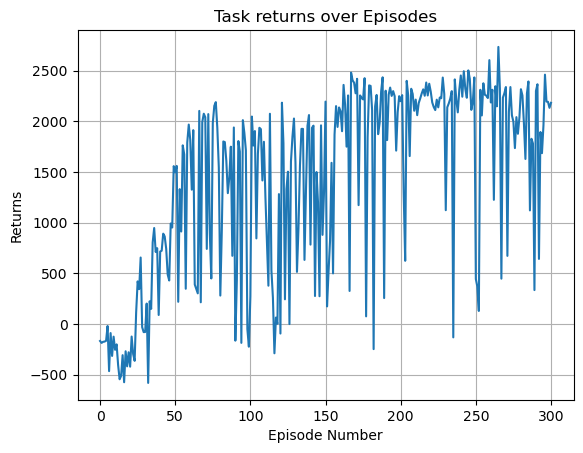

In [10]:
# plot training performance
if not skip_training:
    t.plot(cfg_path=Path().cwd()/'cfg'/'ddpg.yaml',)

In [11]:
# test the trained policy and save a video of the test
if not skip_training:
    t.test(agent, cfg_path=Path().cwd()/'cfg'/'ddpg.yaml', cfg_args=dict(save_video=True,testing=True))

Numpy/Torch/Random Seed:  814
Loading model from /notebooks/rl2025/ex6/results/HalfCheetah-v4/model/HalfCheetah-v4_params.pt ...
Testing ...
Moviepy - Building video /notebooks/rl2025/ex6/results/HalfCheetah-v4/video/test/ex6-episode-0.mp4.
Moviepy - Writing video /notebooks/rl2025/ex6/results/HalfCheetah-v4/video/test/ex6-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /notebooks/rl2025/ex6/results/HalfCheetah-v4/video/test/ex6-episode-0.mp4
Ep0: Test ep_reward is 2430.763283057511
Ep1: Test ep_reward is 2509.2812028401813
Ep2: Test ep_reward is 2233.637941071955
Ep3: Test ep_reward is 2672.0697115328812
Ep4: Test ep_reward is 372.295568691221
Ep5: Test ep_reward is 2359.3756249226553
Ep6: Test ep_reward is -94.98309936615263
Ep7: Test ep_reward is 2084.742027826419
Ep8: Test ep_reward is 2343.205078332248
Moviepy - Building video /notebooks/rl2025/ex6/results/HalfCheetah-v4/video/test/ex6-episode-9.mp4.
Moviepy - Writing video /notebooks/rl2025/ex6/results/HalfCheetah-v4/video/test/ex6-episode-9.mp4



Moviepy - Done !
Moviepy - video ready /notebooks/rl2025/ex6/results/HalfCheetah-v4/video/test/ex6-episode-9.mp4
Ep9: Test ep_reward is 2314.4561684755868
Average test reward: 1922.4843507384508


In [12]:
if not skip_training:
    video = Video(Path().cwd()/'results'/'HalfCheetah-v4'/'video'/'test'/'ex6-episode-0.mp4',
    embed=True, html_attributes="loop autoplay") # Set html_attributes="controls" for video control
    display(video)

In [13]:
%%capture --no-stdout
"TEST"

<a id="Q1"></a>
<div class= "alert alert-warning">
    <h3><b>Student Question 1.1</b> On-policy vs off-policy part 1 (10 points) </h3> 

Why can the Deep Deterministic Policy Gradient (DDPG) algorithm use off-policy data, while policy gradient methods(seen in exercise 5) require on-policy data?
    
🔝	<a href='#TOC'><b>Table of Contents</b></a>
</div>

 <h5><b>Choices</b></h5>
 
 1. In DDPG, the critic can generalize from off-policy data, whereas policy gradient methods require data specific to the current policy for accurate gradient estimates.
 2. Policy gradient methods are more efficient than DDPG, so they do not need off-policy data.
 3. DDPG learns from both on-policy and off-policy data simultaneously, unlike policy gradient methods. 
 4. The actor in DDPG uses a deterministic policy which is computed only over the state distribution, making it possible to use off-policy data.
 5. The critic in DDPG uses Q-learning, which allows it to learn from off-policy data without requiring importance sampling.
 6. The actor and critic both rely on importance sampling to effectively handle off-policy data.
 7. The actor in DDPG is stochastic, so off-policy data is important for training.
 8. In DDPG, the experiences are stored in a replay buffer and sampled to improve the sample efficiency. 
 9. The actor in DDPG uses a stochastic policy which is computed only over the state distribution, making it possible to use off-policy data.
 
Choose **three** most appropriate choices. Choosing more than three options will remove result in 0 points for this task. 

In [16]:
sq1_1 = [1,2,3] # Select the appropriate answer 

The below cells are used for grading.

In [17]:
assert set(sq1_1) < set(range(1, 10))
assert 1 <= len(sq1_1) <= 3

<a id='Q2'></a>
<div class=" alert alert-warning">
    <h3><b>Student Question 1.2</b> On-policy vs off-policy part 2 (10 points) </h3> 

A key advantage of DDPG over policy gradient methods is its ability to utilize off-policy data. However, what are the disadvantes of the deterministic policy gradient compared to the policy gradient method implemented in ex6_PG_AC.ipynb? Give two of them.

🔝	<a href='#TOC'><b>Table of Contents</b></a>
</div>

1 - Poor exploration:
Since DDPG uses a deterministic policy, it relies on external noise (like Ornstein–Uhlenbeck or Gaussian) for exploration. This makes exploration less effective and less diverse than the intrinsic randomness of stochastic policies, which sample actions directly from a distribution.

2 - Higher sensitivity and instability:
Deterministic policies are more sensitive to function approximation errors and hyperparameter tuning. Small errors in the critic or overestimation of Q-values can lead to unstable learning, especially since the policy always picks the same action for a given state (no averaging effect like in stochastic policies).

# 3. Submitting <a id='3.'></a>
Ensure all tasks and questions (in ```ex6_DDPG.ipynb``` and ```ex6_PG_AC.ipynb```) are answered and the necessary plots are saved in the appropriate locations. The relevant plots and files that need to be submitted for this assignment are:


- Training performance plots:
  - `ddpg.png`: Training performance plots in terms of episode and episodic reward for DDPG
<br>

  
- Model files:
  - `ddpg_params.pt`: Trained model


Ensure the model files and plots are saved in correct paths:
- ```results/HalfCheetah-v4/ddpg.png``` Training result
- ```results/HalfCheetah-v4/model/ddpg_params.pt``` Training Model


<span style="color:red"> **# IMPORTANT: DO NOT FORGET ANOTHER TASK IN ```ex6_PG_AC.ipynb```** </span>

In [18]:
# Make sure that skip training is set to True before submission
assert skip_training == True

AssertionError: 

## 3.1 Feedback <a id='3.1'></a>

In order to help the staff of the course as well as the forthcoming students, it would be great if you could answer the following questions in your submission:

1) How much time did you spend solving this exercise? (change the ```hrs``` variable below to a floating point number representing the number of hours taken e.g. 5.43)

In [ ]:
hrs = None

2) Difficulty of each task/question from 1-5 (int or float)

In [ ]:
T1 = None   # Implementing DDPG (20 points)
Q1_1 = None   # Question 1.1 Reasons of using off-policy data (10 points)
Q1_2 = None   # Question 1.2 Disadvantages of DDPG (10 points)

3) How well did you understand the content of the task/question from 1-5? (int or float)

In [ ]:
T1 = None   # Implementing DDPG (20 points)
Q1_1 = None   # Question 1.1 Reasons of using off-policy data (10 points)
Q1_2 = None   # Question 1.2 Disadvantages of DDPG (10 points)

4) General feedback. Consider questions like:

    - Did the content of the lecture relate well with the assignment?
    - To what extent did you find the material to be potentially useful for your research and studies?
    
Please share any additional feedback, suggestions, or comments you have about the lecture, assignment, or course content. Your input is valuable in helping us improve the learning experience.

DOUBLE CLICK HERE TO EDIT, CLEAR THIS TEXT AND ANSWER HERE

# References <a id='3.'></a>
Please use the following section to record references.

[1] Timothy P. Lillicrap et al. "Continuous control with deep reinforcement learning" ICLR 2016 https://arxiv.org/abs/1509.02971